In [1]:
using RData, LightGraphs, Colors, Missings, DataFrames, Gadfly, Plots, CSV, Compose
include("code/BGSM_effective_resistance.jl");
include("code/model_selection.jl");

In [4]:
data = CSV.read("/Users/yosikim/Downloads/chicagocrime.csv", delim = ',');

In [41]:
data1 = data[:,[3;12;18;20;21]];
data1[:Community_Area] = data[:,14]; data1[:Type] = data[:,6];
data1[:X_Coordinate] = data[:,16]; data1[:Y_Coordinate] = data[:,17];
data1[:Month] = 0;
for i = 1:size(data1,1)
    data1[:Month][i] = (Int(data1[:Date][i][1]) - 48) * 10 + Int(data1[:Date][i][2]) - 48
end
nonnull = find((ismissing.(data1[:Month]) .== false) .& (ismissing.(data1[:Year]) .== false)
                .& (ismissing.(data1[:Community_Area]) .== false) .& (ismissing.(data1[:District]) .== false)
                .& (ismissing.(data1[:Latitude]) .== false) .& (ismissing.(data1[:Longitude]) .== false)
               );
data2 = data1[nonnull,:];
community = Array{Int}(data2[:Community_Area]);
district = Array{Int}(data2[:District]);
disappeared_district = find((data2[:District] .!= 13) .& (data2[:District] .!= 21)
                       .& (data2[:District] .!= 23) .& (data2[:District] .!= 31));
data3 = data2[disappeared_district,:];
finalind = find((data3[:X_Coordinate] .> 0) .& (data3[:Y_Coordinate] .> 0));
finaldata = data3[finalind,:];

In [42]:
# see how data look like
finaldata[:Season] = finaldata[:Year] + floor.(finaldata[:Month]/3)/4;
finaldata = finaldata[find(finaldata[:Community_Area] .> 0),:]
head(finaldata)

,Date,District,Year,Latitude,Longitude,Community_Area,Type,X_Coordinate,Y_Coordinate,Month,Season
1,03/18/2015 07:44:00 PM,11,2015,41.8914,-87.7444,25,BATTERY,1144606,1903566,3,2015.25
2,03/18/2015 11:00:00 PM,7,2015,41.7734,-87.6653,67,OTHER OFFENSE,1166468,1860715,3,2015.25
3,03/18/2015 10:45:00 PM,2,2015,41.8139,-87.5966,39,BATTERY,1185075,1875622,3,2015.25
4,03/18/2015 10:30:00 PM,2,2015,41.8008,-87.6226,40,BATTERY,1178033,1870804,3,2015.25
5,03/18/2015 09:00:00 PM,11,2015,41.8781,-87.7434,25,ROBBERY,1144920,1898709,3,2015.25
6,03/18/2015 10:00:00 PM,2,2015,41.8054,-87.6043,39,BATTERY,1183018,1872537,3,2015.25


In [43]:
## discretization of the chicago crime data

lati = floor.(Int,finaldata[:Y_Coordinate]/10^3 * 4 + 0.5); lati = lati - minimum(lati) + 1;
long = floor.(Int,finaldata[:X_Coordinate]/10^3 * 4 + 0.5); long = long - minimum(long) + 1;
n1 = maximum(lati); n2 = maximum(long);
z = zeros(n1*n2); w = zeros(n1*n2); v = zeros(n1,n2);
for i = 1:length(lati)
    ind = (lati[i] - 1) * n2 + long[i];
    z[ind] += 1;
    w[ind] = finaldata[:District][i];
    v[ind] = finaldata[:Community_Area][i];
end
Z = reshape(z,n2,n1)';
W = reshape(w,n2,n1)';
V = reshape(v,n2,n1)';

In [44]:
fdata = copy(finaldata);

In [66]:
## combine data by community area

community_name = 1:77;

community_enumerate = sort(unique(finaldata[:Community_Area]));
community_num = zeros(length(community_name));
community_pop = [54991;71942;56362;39493;31867;94368;64116;80484;11187;37023;
                25448;18508;17931;51542;64124;53359;41932;13426;78743;25010;
                39262;73595;56323;81432;98514;18001;20567;54881;35912;79288;
                35769;29283;21390;13391;18238;5918;2876;21929;17841;11717;
                25681;25983;49767;31028;10185;31198;2916;13812;44619;7325;
                15109;23042;29651;6482;9426;34513;13393;45368;15612;31977;
                44377;18109;39894;23139;33355;55628;35505;30654;32602;41081;
                48743;20034;26493;19093;22544;12756;56521]

for i = 1:length(community_name)
    community_num[i] = sum(V .== community_enumerate[i]);
end

community_dens = community_pop ./ community_num;

In [65]:
## combine data by district

district_name = ["1st District – Central";
"2nd District – Wentworth";
"3rd District – Grand Crossing";
"4th District – South Chicago";
"5th District – Calumet";
"6th District – Gresham";
"7th District – Englewood";
"8th District – Chicago Lawn";
"9th District – Deering";
"10th District – Ogden";
"11th District – Harrison";
"12th District – Near West";
"14th District – Shakespeare";
"15th District – Austin";
"16th District – Jefferson Park";
"17th District – Albany Park";
"18th District – Near North";
"19th District – Town Hall";
"20th District – Lincoln";
"22nd District – Morgan Park";
"24th District – Rogers Park";
"25th District – Grand Central";];

In [112]:
index = [1:9;11;12;16];
year = sort(unique(f1[:Season]))
district_enumerate = sort(unique(f1[:District]));
district_mean = zeros(length(district_name),length(year),length(index));
district_sum = zeros(length(district_name),length(year),length(index));
district_num = zeros(length(district_name));

for k = 1:length(index)
    
    u = unique(fdata[:Type])[index[k]];
    f1 = fdata[fdata[:Type] .== u,:]

    for i = 1:length(district_name)
        district_num[i] = sum(W .== district_enumerate[i]);
        ind = findin(f1[:District], district_enumerate[i]);
        for j = 1:length(year)
            district_sum[i,j,k] = sum(f1[:Season][ind] .== year[j]);
            district_mean[i,j,k] = district_sum[i,j,k]/district_num[i];
        end
        
        println(i)
    end
    
    println(k,"-th done")
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
1-th done
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
2-th done
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
3-th done
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
4-th done
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
5-th done
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
6-th done
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
7-th done
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
8-th done
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
9-th done
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
10-th done
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
11-th done
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
12-th done


In [131]:
Array{String,1}(unique(fdata[:Type]))[[1:9;11;12;16]]

12-element Array{String,1}:
 "BATTERY"            
 "OTHER OFFENSE"      
 "ROBBERY"            
 "NARCOTICS"          
 "CRIMINAL DAMAGE"    
 "WEAPONS VIOLATION"  
 "THEFT"              
 "BURGLARY"           
 "MOTOR VEHICLE THEFT"
 "ASSAULT"            
 "CRIMINAL TRESPASS"  
 "DECEPTIVE PRACTICE" 

In [203]:
A = zeros(8,71,12);
A[1,:,:] = district_mean[1,:,:];
A[2,:,:] = district_mean[2,:,:]/3 + district_mean[5,:,:]/3 + district_mean[6,:,:]/3;
A[3,:,:] = district_mean[3,:,:]/2 + district_mean[7,:,:]/2;
A[4,:,:] = district_mean[11,:,:];
A[5,:,:] = district_mean[13,:,:];
A[6,:,:] = district_mean[14,:,:];
A[7,:,:] = district_mean[17,:,:];
A[8,:,:] = district_mean[4,:,:] + district_mean[8,:,:] + district_mean[9,:,:] + district_mean[10,:,:] +
            district_mean[12,:,:] + district_mean[13,:,:] + district_mean[15,:,:] + district_mean[16,:,:] + 
            district_mean[18,:,:] + district_mean[19,:,:] + district_mean[20,:,:] + district_mean[21,:,:] +
            district_mean[22,:,:];
A[8,:,:] = A[8,:,:] / 13;

In [211]:
include("code/BGSM_cartesian_biclust.jl");
X = reshape(mean(A,2),8,12);

8×12 Array{Float64,2}:
 0.260937  0.125355   0.0687386  …  0.113947   0.206238   0.245537 
 0.350217  0.10712    0.0775019     0.122853   0.0522879  0.0525559
 0.548981  0.153195   0.108209      0.17694    0.0735106  0.0560631
 0.546682  0.126121   0.115865      0.163566   0.0500451  0.0618923
 0.242752  0.0818322  0.0619593     0.0855658  0.0328847  0.0589083
 0.639107  0.176817   0.123455   …  0.187085   0.0592458  0.0592344
 0.288436  0.083932   0.0623077     0.0816135  0.123511   0.211368 
 0.204046  0.0768979  0.0425295     0.0699193  0.0301349  0.0467556

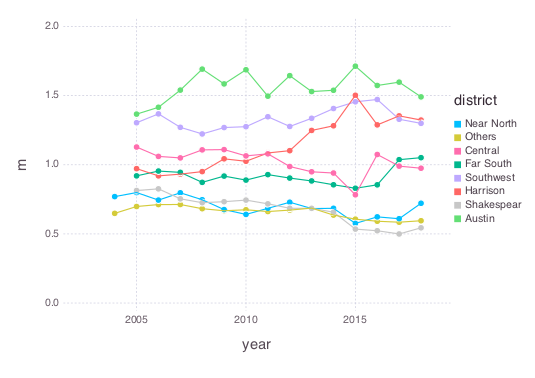

In [206]:
y = reshape(sum(reshape(A[:,3:70,2]',4,17*8),1)[:],17,8)';
df1 = DataFrame(y = y[:],
    m = (y ./ mean(y,1))[:],
    district = repeat(["Central";"Far South";"Southwest";"Harrison";
            "Shakespear";"Austin";"Near North";"Others"], outer = 17),
    year = repeat(2002:2018, inner = 8));
Gadfly.plot(df1[23:end,:], x = :year, y = :m, color = :district, Geom.line, Geom.point,
    Coord.Cartesian(xmin = 2002, xmax = 2019))